In [140]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from astropy.io import ascii
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter
# from scipy.integrate import quad

# Time range around the horizon crossing
startTime = 390+1.92224*10**8
stopTime = 500+1.92224*10**8

# indices for the event file
startTimeIndex = 311883
stopTimeIndex = 352360

# read in the data files
# read in the data files
tab_ni = Table.read('ni2200300102.mkf', hdu=1)
timeArray = np.array(tab_ni['TIME'])
elevArray = np.array(tab_ni['ELV'])
azArray = np.array(tab_ni['RAM_ANGLE'])
location = np.array(tab_ni['POSITION'])
locationX = location[:,0]
locationY = location[:,1]
locationZ = location[:,2]

tab_evt = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tab_evt['TIME'][startTimeIndex:stopTimeIndex])
enArray = np.array(tab_evt['PI'][startTimeIndex:stopTimeIndex])


def Interpolator(col_mkf):
    f = interpolate.interp1d(timeArray, col_mkf, kind='linear')
    return f(eventTime)

elev_evt = Interpolator(elevArray)
az_evt = Interpolator(azArray)
Xcoord = Interpolator(locationX)
Ycoord = Interpolator(locationY)
Zcoord = Interpolator(locationZ)

# calculate altitude based on elevation angle
R = 6378
H = 410
theta = np.arcsin(R/(R+H))
altArray = []
for indx, val in enumerate(elev_evt):
    h = (((R+H)*np.sin(theta+val*(np.pi/180)))-R)*np.cos(az_evt[indx]*np.pi/180)
    altArray.append(np.float(h))
altArray = np.array(altArray)


# read in MSIS model data
data = ascii.read("msis_model.txt")

height = np.array(data['km'])
density = np.array(data['g/cm^3'])
temp = np.array(data['K'])


def msisSync(Y_msis):
    height[0] = altArray[0]
    height[len(height)-1] = altArray[len(altArray)-1]
    func = interpolate.interp1d(height, Y_msis)
    return np.array(func(altArray))


msisRho = msisSync(density)
msisT = msisSync(temp)


# bin size and energy band cutoffs
binSize_all = 1
lowEn = [30, 70]
lowMidEn = [70, 100]
lowMidEn1 = [70, 80]
lowMidEn2 = [80, 90]
lowMidEn3 = [90, 100]
midEn = [100, 200]
highEn = [200, 600]
allEn = [0, 600]


class EnergyBands:

    def __init__(self, energy_band, bin_size):
        self.energy_band = energy_band
        self.bin_size = bin_size
        self.time, self.energies = enSplit(energy_band)
        self.alt = altSplit(energy_band)
        self.rate, self.new_alt, self.binTime, self.binnedEnergy, self.binnedX, self.binnedY, self.binnedZ = countRate(self)
        self.T_pre = msisSplit(self.alt, energy_band, msisT)
        self.rho_pre = msisSplit(self.alt, energy_band, msisRho)
        self.rho_msis, self.T_msis = countRateSync(self.time, self.alt, self.rho_pre, self.T_pre, bin_size)
        self.time_axis = Axis(self.rate, bin_size)
        self.perc_trans = percTrans(self.new_alt, self.rate)
        self.L_msis = atmHeight(self.T_msis)
        self.sigma = Sigma(self.energies)
        self.sigmafit_popt, self.sigmafit_pcov = modelFit_sigma(self.perc_trans, self.new_alt, self.rho_msis)



# Time axis
def Axis(Rate, binSize):
    return np.arange(0, len(Rate), binSize)


# function that splits the altitudes based on energy bands
def altSplit(energy_level):
    index = np.where((enArray >= energy_level[0]) & (enArray < energy_level[1]))
    return altArray[index[0]]


# function that deduces the number of counts per bin size
def countRate(self):
    binCounts = []
    binTime = []
    altitude = []
    binnedEnergy = []
    binnedX = []
    binnedY = []
    binnedZ = []
    for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
        desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
        if len(self.alt[desind[0]]) != 0:
            binCounts.append(np.size(desind[0]))
            altitude.append(np.mean(self.alt[desind[0]]))
            binTime.append(np.mean(self.time[desind[0]]))
            binnedEnergy.append(np.mean(self.energies[desind[0]]))
            binnedX.append(np.mean(Xcoord[desind[0]]))
            binnedY.append(np.mean(Ycoord[desind[0]]))
            binnedZ.append(np.mean(Zcoord[desind[0]]))
    return np.array(binCounts), np.array(altitude), np.array(binTime), np.array(binnedEnergy), np.array(binnedX), np.array(binnedY), np.array(binnedZ)


def countRateSync(Time, alt_array, msis_rho, msis_temp, binSize):
    rho = []
    temp = []
    for i in np.arange(min(Time), max(Time)+binSize, binSize):
        desind = np.where((Time >= i) & (Time < i + binSize))
        if len(alt_array[desind[0]]) != 0.:
            rho.append(np.mean(msis_rho[desind[0]]))
            temp.append(np.mean(msis_temp[desind[0]]))
    return  np.array(rho), np.array(temp)


# function that makes a list of times corresponding to each energy range
def enSplit(energy_level):
    index = np.where((enArray >= energy_level[0]) & (enArray < energy_level[1]))
    return eventTime[index[0]], enArray[index[0]]/100


def percTrans(Alt, Rate):
    plateau = np.where(((Alt > 200) & (Alt < 250)))
    avg = np.mean(Rate[plateau[0]])
    return (Rate/avg)*100


# functions to make the atmospheric model
# altArray=h in mathematica
k = 1.38064852*10**-23
# T = 500
mu = 28
mp = 1.6726219*10**-27
g = 9.8
# L = (k*T)/(1000*mu*mp*g)
z0 = 135
# p0 = 0.0012*np.exp(-z0/L)


def atmHeight(Temperature):
    return np.array((k*Temperature)/(1000*mu*mp*g))


def Sigma(energy):
    c = np.float(-3)
    return (274.6)*(energy)**c+11.26


# i is the index in altArray
def Z(x, i, Alt):
    return np.sqrt(x**2+(R+Alt[i])**2)-R


# def Rho(x, i, Alt, p0, l):
    # return p0*np.exp(-(Z(x, i, Alt)-z0)/l)


# numerical integration
def Transmit(Alt, msisRho, sigma):
    elem = 500
    tau = []
    dist = 2*np.sqrt((R+H)**2-(R+Alt)**2)
    for hi in range(len(Alt)):
        g = np.float(0)
        x2 = (dist[hi]*10**5)/2
        X = np.linspace(0, x2, elem)
        for n in X:
            dx = x2/elem
            g += msisRho[hi]*dx #this used to refer to Rho()
        tau.append(-2*sigma*g)
    tau = np.array(tau)
    trans = 100*np.exp(tau)
    return np.array(trans)


def msisSplit(desiredAlt, energy_level, msis_col):
    index = np.where((enArray >= energy_level[0]) & (enArray < energy_level[1]))
    return msis_col[index[0]]


def modelFit_sigma(percTrans, Alt, Density):
    popt, pcov = curve_fit(lambda Alt, sigma: Transmit(Alt, Density, sigma), 
                       Alt, percTrans)
    return popt, pcov

In [141]:
all_en = EnergyBands(allEn, binSize_all)
low_en = EnergyBands(allEn, binSize_all)

In [116]:
t50 = all_en.binTime[np.where(all_en.perc_trans > 50)[0][0]]
alt50 = all_en.new_alt[np.where(all_en.perc_trans > 50)[0][0]]

In [117]:
t1e = all_en.binTime[np.where(all_en.perc_trans > (1/np.exp(1))*100)[0][0]]
alt1e = all_en.new_alt[np.where(all_en.perc_trans > (1/np.exp(1))*100)[0][0]]

In [118]:
t2e = all_en.binTime[np.where(all_en.perc_trans > (2/np.exp(1)*100))[0][0]]
alt2e = all_en.new_alt[np.where(all_en.perc_trans > (2/np.exp(1))*100)[0][0]]

In [119]:
def convert_time(time):

    timezero = datetime.datetime(year=2014, month=1,
                                 day=1, hour=0, minute=0, second=0)
    new_time = timezero + datetime.timedelta(seconds=time)

    return new_time


In [120]:
print(f'The dateTime for the 1/e crossing is: {convert_time(t1e)}')
print(f'The dateTime for the 50% crossing is: {convert_time(t50)}')
print(f'The dateTime for the 2/e crossing is: {convert_time(t2e)}')

The dateTime for the 1/e crossing is: 2020-02-03 19:40:18.133392
The dateTime for the 50% crossing is: 2020-02-03 19:40:20.125719
The dateTime for the 2/e crossing is: 2020-02-03 19:40:27.142034


In [121]:
print(f'The altitude for the 1/e crossing is: {convert_time(alt1e)}')
print(f'The altitude for the 50% crossing is: {convert_time(alt50)}')
print(f'The altitude for the 2/e crossing is: {convert_time(alt2e)}')

The altitude for the 1/e crossing is: 2014-01-01 00:01:49.108956
The altitude for the 50% crossing is: 2014-01-01 00:01:53.496979
The altitude for the 2/e crossing is: 2014-01-01 00:02:08.417687


In [122]:
t0 = all_en.binTime[np.where(all_en.perc_trans > (0))[0][0]]
t1 = all_en.binTime[np.where(all_en.perc_trans > (1))[0][0]]
t10 = all_en.binTime[np.where(all_en.perc_trans > (10))[0][0]]
t20 = all_en.binTime[np.where(all_en.perc_trans > (20))[0][0]]
t30 = all_en.binTime[np.where(all_en.perc_trans > (30))[0][0]]
t40 = all_en.binTime[np.where(all_en.perc_trans > (40))[0][0]]
t50 = all_en.binTime[np.where(all_en.perc_trans > (50))[0][0]]
t60 = all_en.binTime[np.where(all_en.perc_trans > (60))[0][0]]
t70 = all_en.binTime[np.where(all_en.perc_trans > (70))[0][0]]
t80 = all_en.binTime[np.where(all_en.perc_trans > (80))[0][0]]
t90 = all_en.binTime[np.where(all_en.perc_trans > (90))[0][0]]
t100 = all_en.binTime[np.where(all_en.perc_trans >= (100))[0][0]]
crossingTimes = np.array([t1, t10, t20, t30, t40, t50, t60, t70, t80, t90, t100])

In [123]:
print(f'The dateTime for the 1% crossing is: {convert_time(t1)}')
print(f'The dateTime for the 10% crossing is: {convert_time(t10)}')
print(f'The dateTime for the 20% crossing is: {convert_time(t20)}')
print(f'The dateTime for the 30% crossing is: {convert_time(t30)}')
print(f'The dateTime for the 40% crossing is: {convert_time(t40)}')
print(f'The dateTime for the 50% crossing is: {convert_time(t50)}')
print(f'The dateTime for the 60% crossing is: {convert_time(t60)}')
print(f'The dateTime for the 70% crossing is: {convert_time(t70)}')
print(f'The dateTime for the 80% crossing is: {convert_time(t80)}')
print(f'The dateTime for the 90% crossing is: {convert_time(t90)}')
print(f'The dateTime for the 100% crossing is: {convert_time(t100)}')

The dateTime for the 1% crossing is: 2020-02-03 19:40:06.312903
The dateTime for the 10% crossing is: 2020-02-03 19:40:11.126916
The dateTime for the 20% crossing is: 2020-02-03 19:40:13.123182
The dateTime for the 30% crossing is: 2020-02-03 19:40:15.171568
The dateTime for the 40% crossing is: 2020-02-03 19:40:18.133392
The dateTime for the 50% crossing is: 2020-02-03 19:40:20.125719
The dateTime for the 60% crossing is: 2020-02-03 19:40:21.120960
The dateTime for the 70% crossing is: 2020-02-03 19:40:27.142034
The dateTime for the 80% crossing is: 2020-02-03 19:40:32.136859
The dateTime for the 90% crossing is: 2020-02-03 19:40:39.132899
The dateTime for the 100% crossing is: 2020-02-03 19:40:44.108576


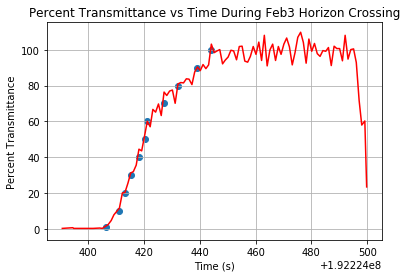

In [124]:
plt.title('Percent Transmittance vs Time During Feb3 Horizon Crossing')
plt.xlabel('Time (s)')
plt.ylabel('Percent Transmittance')
plt.plot(all_en.binTime, all_en.perc_trans, 'r-')
times = [t1, t10, t20, t30, t40, t50, t60, t70, t80, t90, t100]
perc_times = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.scatter(times, perc_times)
plt.grid()

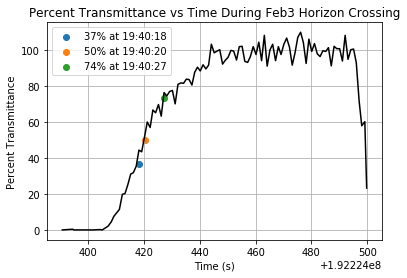

In [125]:
disp_t1e = str(convert_time(t1e))
disp_t50 = str(convert_time(t50))
disp_t2e = str(convert_time(t2e))

plt.title('Percent Transmittance vs Time During Feb3 Horizon Crossing')
plt.xlabel('Time (s)')
plt.ylabel('Percent Transmittance')
plt.plot(all_en.binTime, all_en.perc_trans, 'k-')
plt.scatter(t1e, 100*(1/np.exp(1)), label = '37' + str('%') + ' at %s' % disp_t1e[11:19])
plt.scatter(t50, 50, label = r'50' + str('%') + ' at %s' % disp_t50[11:19])
plt.scatter(t2e, 100*(2/np.exp(1)), label = '74' + str('%') + ' at %s' % disp_t2e[11:19])
plt.legend()
plt.grid()

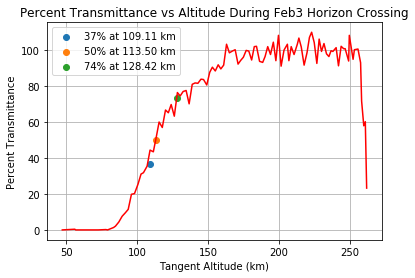

In [126]:
plt.title('Percent Transmittance vs Altitude During Feb3 Horizon Crossing')
plt.xlabel('Tangent Altitude (km)')
plt.ylabel('Percent Transmittance')
plt.plot(all_en.new_alt, all_en.perc_trans, 'r-')
plt.scatter(alt1e, 100*(1/np.exp(1)), label = '37' + str('%') + ' at ''%.2f km' % alt1e)
plt.scatter(alt50, 50, label = r'50' + str('%') + ' at ''%.2f km' % alt50)
plt.scatter(alt2e, 100*(2/np.exp(1)), label = '74' + str('%') + ' at ''%.2f km' % alt2e)
plt.legend()
plt.grid()

In [127]:
alt1 = all_en.new_alt[np.where(all_en.perc_trans > (1))[0][0]]
alt10 = all_en.new_alt[np.where(all_en.perc_trans > (10))[0][0]]
alt20 = all_en.new_alt[np.where(all_en.perc_trans > (20))[0][0]]
alt30 = all_en.new_alt[np.where(all_en.perc_trans > (30))[0][0]]
alt40 = all_en.new_alt[np.where(all_en.perc_trans > (40))[0][0]]
alt50 = all_en.new_alt[np.where(all_en.perc_trans > (50))[0][0]]
alt60 = all_en.new_alt[np.where(all_en.perc_trans > (60))[0][0]]
alt70 = all_en.new_alt[np.where(all_en.perc_trans > (70))[0][0]]
alt80 = all_en.new_alt[np.where(all_en.perc_trans > (80))[0][0]]
alt90 = all_en.new_alt[np.where(all_en.perc_trans > (90))[0][0]]
alt100 = all_en.new_alt[np.where(all_en.perc_trans >= (100))[0][0]]

In [128]:
print(f'The tangent altitude for the 1% crossing is: {alt1} km')
print(f'The tangent altitude for the 10% crossing is: {alt10} km')
print(f'The tangent altitude for the 20% crossing is: {alt20} km')
print(f'The tangent altitude for the 30% crossing is: {alt30} km')
print(f'The tangent altitude for the 40% crossing is: {alt40} km')
print(f'The tangent altitude for the 50% crossing is: {alt50} km')
print(f'The tangent altitude for the 60% crossing is: {alt60} km')
print(f'The tangent altitude for the 70% crossing is: {alt70} km')
print(f'The tangent altitude for the 80% crossing is: {alt80} km')
print(f'The tangent altitude for the 90% crossing is: {alt90} km')
print(f'The tangent altitude for the 100% crossing is: {alt100} km')

The tangent altitude for the 1% crossing is: 83.33803642570547 km
The tangent altitude for the 10% crossing is: 93.69004149652108 km
The tangent altitude for the 20% crossing is: 98.12572618631307 km
The tangent altitude for the 30% crossing is: 102.73489690878958 km
The tangent altitude for the 40% crossing is: 109.1089556195348 km
The tangent altitude for the 50% crossing is: 113.49697941751572 km
The tangent altitude for the 60% crossing is: 115.49610133794333 km
The tangent altitude for the 70% crossing is: 128.4176868524896 km
The tangent altitude for the 80% crossing is: 138.888682142818 km
The tangent altitude for the 90% crossing is: 153.11564378341012 km
The tangent altitude for the 100% crossing is: 163.12095514277638 km


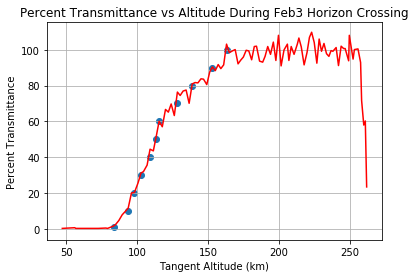

In [129]:
plt.title('Percent Transmittance vs Altitude During Feb3 Horizon Crossing')
plt.xlabel('Tangent Altitude (km)')
plt.ylabel('Percent Transmittance')
plt.plot(all_en.new_alt, all_en.perc_trans, 'r-')
alts = [alt1, alt10, alt20, alt30, alt40, alt50, alt60, alt70, alt80, alt90, alt100]
perc_times = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.scatter(alts, perc_times)
plt.grid()

(50, 215)

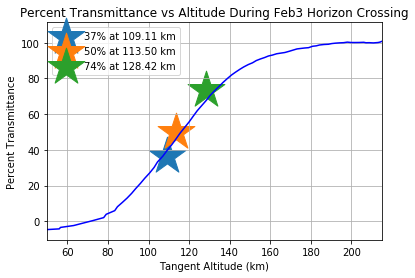

In [130]:
plt.title('Percent Transmittance vs Altitude During Feb3 Horizon Crossing')
plt.xlabel('Tangent Altitude (km)')
plt.ylabel('Percent Transmittance')
#plt.plot(all_en.new_alt, all_en.perc_trans, 'g*')
perc_smooth = savgol_filter(all_en.perc_trans, 51, 3)
plt.plot(all_en.new_alt, perc_smooth, 'b')
plt.scatter(alt1e, 100*(1/np.exp(1)), s=1500, marker='*', label = '37' + str('%') + ' at ''%.2f km' % alt1e)
plt.scatter(alt50, 50, s=1500, marker='*', label = r'50' + str('%') + ' at ''%.2f km' % alt50)
plt.scatter(alt2e, 100*(2/np.exp(1)), s=1500, marker='*', label = '74' + str('%') + ' at ''%.2f km' % alt2e)
plt.legend()
plt.grid()
plt.xlim(50, 215)

In [131]:
#Energy bands
width = 20 #0.1 keV
for val in np.arange(20, 220, width):
    locals()["EnRange"+str(val)] = [val, val+width]
    locals()["En"+str(val)] = EnergyBands(locals()["EnRange"+str(val)], binSize_all)

(192224400.0, 192224470.0)

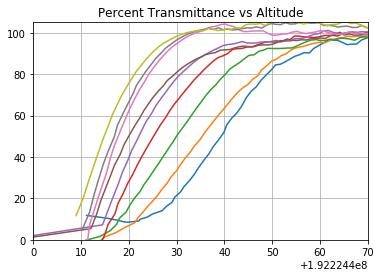

In [132]:
plt.title('Percent Transmittance vs Altitude')
plt.plot(En40.binTime, savgol_filter(En40.perc_trans, 51, 3))
plt.plot(En60.binTime, savgol_filter(En60.perc_trans, 51, 3))
plt.plot(En80.binTime, savgol_filter(En80.perc_trans, 51, 3))
plt.plot(En100.binTime, savgol_filter(En100.perc_trans, 51, 3))
plt.plot(En120.binTime, savgol_filter(En120.perc_trans, 51, 3))
plt.plot(En140.binTime, savgol_filter(En140.perc_trans, 51, 3))
plt.plot(En160.binTime, savgol_filter(En160.perc_trans, 51, 3))
plt.plot(En180.binTime, savgol_filter(En180.perc_trans, 51, 3))
plt.plot(En200.binTime, savgol_filter(En200.perc_trans, 51, 3))
plt.grid()
plt.ylim(0, 105)
plt.xlim(1.92224e8+np.array([400, 470]))

(0, 105)

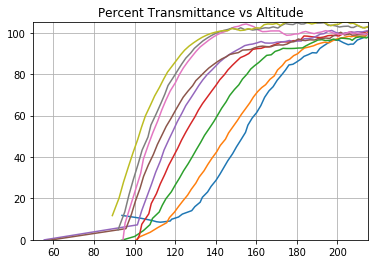

In [133]:
plt.title('Percent Transmittance vs Altitude')
plt.plot(En40.new_alt, savgol_filter(En40.perc_trans, 51, 3))
plt.plot(En60.new_alt, savgol_filter(En60.perc_trans, 51, 3))
plt.plot(En80.new_alt, savgol_filter(En80.perc_trans, 51, 3))
plt.plot(En100.new_alt, savgol_filter(En100.perc_trans, 51, 3))
plt.plot(En120.new_alt, savgol_filter(En120.perc_trans, 51, 3))
plt.plot(En140.new_alt, savgol_filter(En140.perc_trans, 51, 3))
plt.plot(En160.new_alt, savgol_filter(En160.perc_trans, 51, 3))
plt.plot(En180.new_alt, savgol_filter(En180.perc_trans, 51, 3))
plt.plot(En200.new_alt, savgol_filter(En200.perc_trans, 51, 3))
plt.grid()
plt.xlim(50, 215)
plt.ylim(0,105)

In [134]:
crossingTimes = np.array([t1, t10, t20, t30, t40, t50, t60, t70, t80, t90, t100])
crossingAlts = np.array([alt1, alt10, alt20, alt30, alt40, alt50, alt60, alt70, alt80, alt90, alt100])
transmitIndices = np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [230]:
newEnRange = [85, 120]
newEn = EnergyBands(newEnRange, binSize_all)

def Transmit2():
    Alt = newEn.new_alt
    elem1 = 500
    elem2 = 500
    tau = []
    halfDist = np.sqrt((R+H)**2-(R+Alt)**2)
    for hi in range(len(Alt)):
        g = 0
        upperBound1 = halfDist[hi]*10**5
        upperBound2 = 1000*10**5
        X1 = np.linspace(0, upperBound1, elem1)
        X2 = np.linspace(0, upperBound2, elem2)
        for n in X1:
            dx1 = upperBound1/elem1
            g += newEn.rho_msis[hi]*dx1
        
        for n in X2:
            dx2 = upperBound2/elem2
            g += newEn.rho_msis[hi]*dx2
        
        tau.append(-2*Sigma(newEn.energies[hi])*g)
    tau = np.array(tau)
    trans = 100*np.exp(tau)
        
    return np.array(trans), np.array(Alt)

In [231]:
#incase we want a range of altitudes that don't have exact mappings to data points
def timeCorrespond(altIn):
    tc = interpolate.interp1d(newEn.new_alt, newEn.binTime, kind='linear')
    return np.array(tc(altIn))

def CoordCorrespond(coordList, altIn):
    func = interpolate.interp1d(newEn.new_alt, coordList, kind='linear')
    return np.array(func(altIn))

In [232]:
transmit = Transmit2()[0]
alt = Transmit2()[1]
times = timeCorrespond(alt)
newX = CoordCorrespond(newEn.binnedX, alt)
newY = CoordCorrespond(newEn.binnedY, alt)
newZ = CoordCorrespond(newEn.binnedZ, alt)
    
for i in range(len(alt)-1):
    print('%.2f' %transmit[i] + str('%') + ': %.2fkm' %alt[i] + f' at {convert_time(times[i])} || ECI (km): ({newX[i]}, {newY[i]}, {newZ[i]})')

0.00%: 56.61km at 2020-02-03 19:39:54.681584 || ECI (km): (-4546.9159035302, 3706.032357663542, -3434.4673813432964)
0.00%: 83.53km at 2020-02-03 19:40:06.383438 || ECI (km): (-4551.96700480266, 3684.438902271322, -3450.9882781903216)
0.00%: 89.55km at 2020-02-03 19:40:09.197630 || ECI (km): (-4552.229914886644, 3683.3032510546764, -3451.8539837010176)
0.00%: 99.95km at 2020-02-03 19:40:13.931097 || ECI (km): (-4552.538293068006, 3681.971198470219, -3452.8694057302455)
0.00%: 102.43km at 2020-02-03 19:40:14.953113 || ECI (km): (-4556.334793288384, 3665.448984375562, -3465.4313082240005)
0.00%: 103.97km at 2020-02-03 19:40:15.923919 || ECI (km): (-4560.156764603882, 3648.5755887861887, -3478.195879484094)
0.00%: 107.65km at 2020-02-03 19:40:17.439278 || ECI (km): (-4565.441353075793, 3624.8447479187816, -3496.0432519243986)
0.00%: 109.17km at 2020-02-03 19:40:18.160108 || ECI (km): (-4567.866303298148, 3613.818141126367, -3504.3005491123304)
0.00%: 111.57km at 2020-02-03 19:40:19.169677

In [258]:
alphaExpected = (180/np.pi)*np.arctan2(newY, newX)
deltaExpected = (180/np.pi)*np.arcsin(newZ/np.sqrt(newX**2+newY**2+newZ**2))

In [283]:
alphaStar = 274.84
crossingAlpha = 180 - np.rad2deg(np.arcsin((R+alt)/(R+H))) + alphaStar

In [284]:
crossingAlpha

array([383.40922041, 382.68199962, 382.51555834, 382.22394542,
       382.1538439 , 382.1101512 , 382.00520469, 381.96167096,
       381.89276481, 381.82960714, 381.78033561, 381.71405018,
       381.64411684, 381.58806863, 381.52326145, 381.46231926,
       381.39827371, 381.33732718, 381.27768276, 381.21653486,
       381.14837156, 381.08565607, 381.0238546 , 380.96191721,
       380.89865936, 380.84132424, 380.7739488 , 380.70515894,
       380.65114511, 380.58506029, 380.52397071, 380.46392116,
       380.39761299, 380.33790236, 380.27738036, 380.20645965,
       380.14259251, 380.07764945, 380.01735558, 379.95996218,
       379.88788806, 379.83176114, 379.76693506, 379.70609224,
       379.65373761, 379.58179279, 379.50906153, 379.4526473 ,
       379.38904855, 379.32597598, 379.25430729, 379.19217963,
       379.13344721, 379.0651093 , 378.99385153, 378.91767965,
       378.87987094, 378.82306297, 378.75516356, 378.67205576,
       378.63118096, 378.57114782, 378.50059426, 378.42

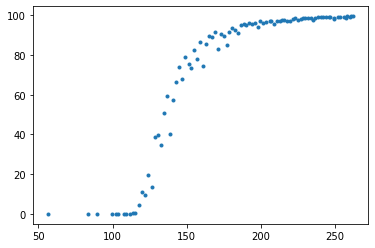

In [255]:
plt.plot(alt, transmit, '.')

In [253]:
def tabulateTrans():
    return np.arange(0, 100, 1)

def tabulateAlt(percTrans, Alt):
    func = interpolate.interp1d(percTrans, Alt)
    return func(tabulateTrans())

    

tableAlt = tabulateAlt(transmit, alt)
tableTrans = tabulateTrans()

In [254]:
for i in range(len(tableAlt)-1):
    print('%.2f' %tableTrans[i] + str('%') + ': %.2fkm' %tableAlt[i])

0.00%: 83.53km
1.00%: 114.12km
2.00%: 115.10km
3.00%: 116.08km
4.00%: 117.05km
5.00%: 118.00km
6.00%: 118.85km
7.00%: 119.71km
8.00%: 120.56km
9.00%: 121.42km
10.00%: 121.63km
11.00%: 120.48km
12.00%: 122.64km
13.00%: 124.79km
14.00%: 126.23km
15.00%: 125.87km
16.00%: 125.50km
17.00%: 125.14km
18.00%: 124.78km
19.00%: 124.41km
20.00%: 124.60km
21.00%: 125.13km
22.00%: 125.66km
23.00%: 126.20km
24.00%: 126.73km
25.00%: 127.26km
26.00%: 127.80km
27.00%: 128.33km
28.00%: 128.86km
29.00%: 129.40km
30.00%: 129.93km
31.00%: 130.46km
32.00%: 131.00km
33.00%: 131.53km
34.00%: 132.06km
35.00%: 132.49km
36.00%: 131.34km
37.00%: 130.20km
38.00%: 129.06km
39.00%: 129.40km
40.00%: 134.25km
41.00%: 138.72km
42.00%: 138.31km
43.00%: 137.90km
44.00%: 137.48km
45.00%: 137.07km
46.00%: 136.66km
47.00%: 136.24km
48.00%: 135.83km
49.00%: 135.42km
50.00%: 135.00km
51.00%: 134.65km
52.00%: 135.66km
53.00%: 136.67km
54.00%: 137.67km
55.00%: 138.68km
56.00%: 139.69km
57.00%: 140.70km
58.00%: 139.51km
59.00%: 

In [286]:
print('Expected right ascension and declination based on (x,y,z) coordinates:')
for i in range(len(alphaExpected)-1):
    print('alpha: %.2f degrees' %alphaExpected[i] + ', delta: %.2f degrees' %deltaExpected[i])

Expected right ascension and declination based on (x,y,z) coordinates:
alpha: 140.82 degrees, delta: -30.35 degrees
alpha: 141.01 degrees, delta: -30.51 degrees
alpha: 141.02 degrees, delta: -30.52 degrees
alpha: 141.03 degrees, delta: -30.53 degrees
alpha: 141.18 degrees, delta: -30.65 degrees
alpha: 141.34 degrees, delta: -30.78 degrees
alpha: 141.55 degrees, delta: -30.95 degrees
alpha: 141.65 degrees, delta: -31.03 degrees
alpha: 141.69 degrees, delta: -31.07 degrees
alpha: 141.74 degrees, delta: -31.11 degrees
alpha: 141.80 degrees, delta: -31.15 degrees
alpha: 141.84 degrees, delta: -31.19 degrees
alpha: 141.88 degrees, delta: -31.21 degrees
alpha: 141.91 degrees, delta: -31.24 degrees
alpha: 141.94 degrees, delta: -31.27 degrees
alpha: 141.98 degrees, delta: -31.30 degrees
alpha: 142.01 degrees, delta: -31.32 degrees
alpha: 142.04 degrees, delta: -31.35 degrees
alpha: 142.08 degrees, delta: -31.38 degrees
alpha: 142.10 degrees, delta: -31.40 degrees
alpha: 142.13 degrees, delta: